In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
import time
import os
from IPython.core.debugger import set_trace
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats



In [22]:
df=pd.read_csv('/content/yahoo_stock.csv',index_col='Date')

In [23]:
df.corr()

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.998154,0.999328,0.998958,0.084212,0.998958
Low,0.998154,1.000000,0.998794,0.999020,0.044557,0.999020
Open,0.999328,0.998794,1.000000,0.998344,0.069729,0.998344
Close,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000
Volume,0.084212,0.044557,0.069729,0.063401,1.000000,0.063401
Adj Close,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000


<Axes: xlabel='Date'>

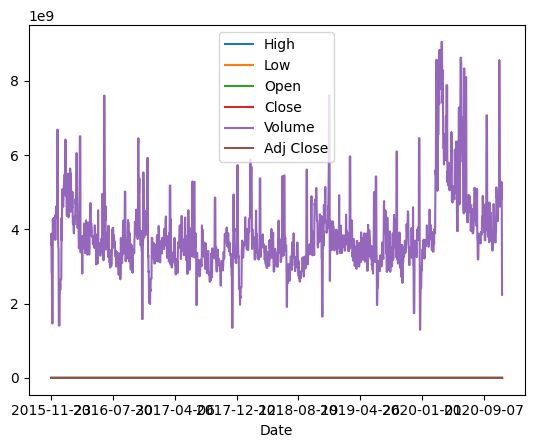

In [24]:
df.plot()

In [25]:
#checking datatypes for features
df.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [26]:
#Transofrming the Date Index Column into a date_time format
df.index=pd.to_datetime(df.index)
df.index.month

Index([11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
       ...
       11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
      dtype='int32', name='Date', length=1825)

In [27]:
#Checking for missing values:
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

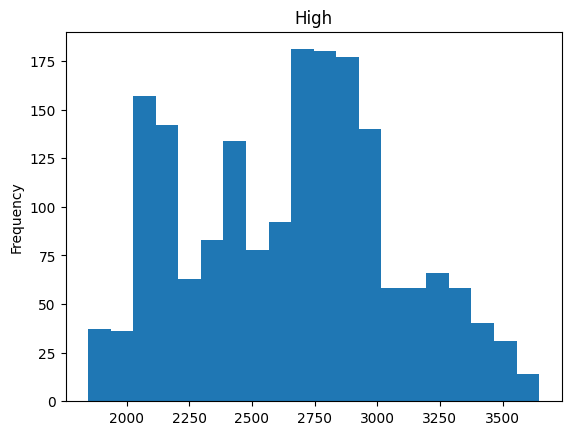

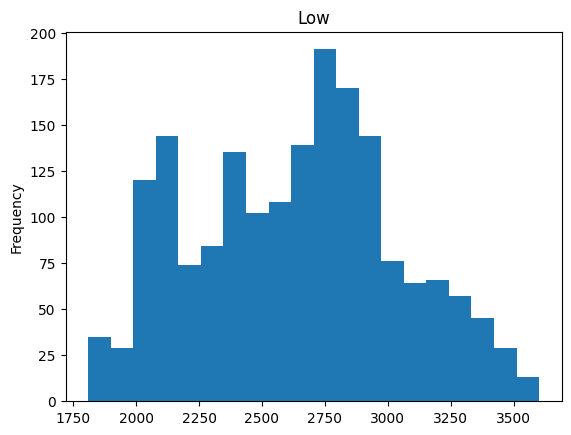

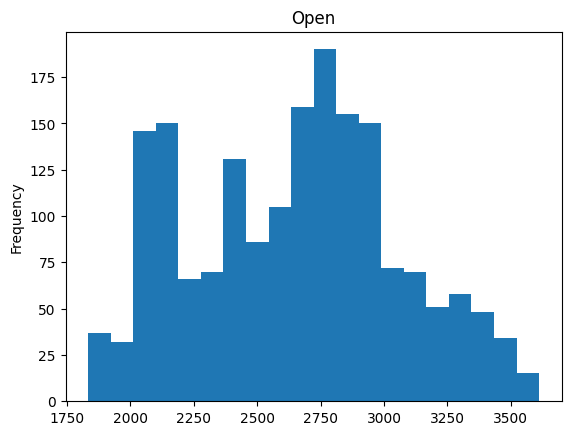

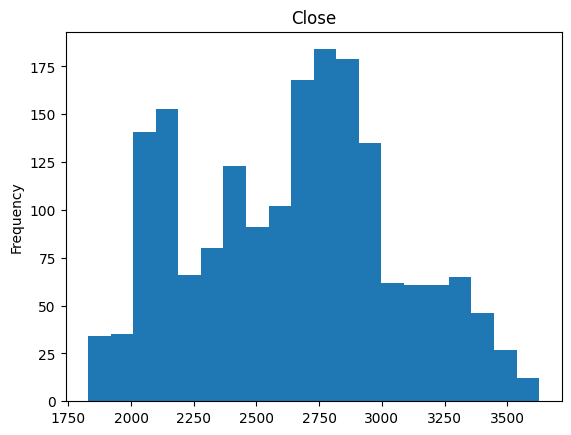

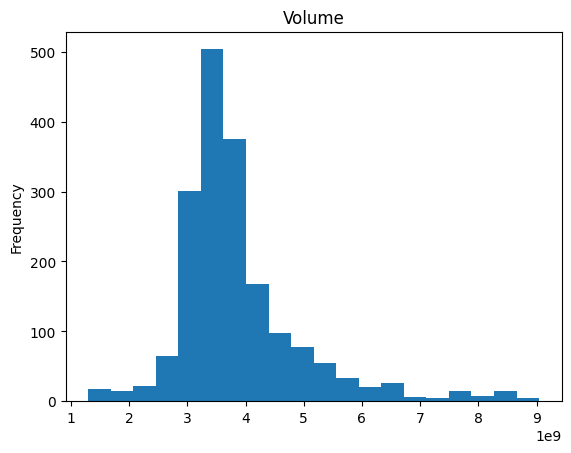

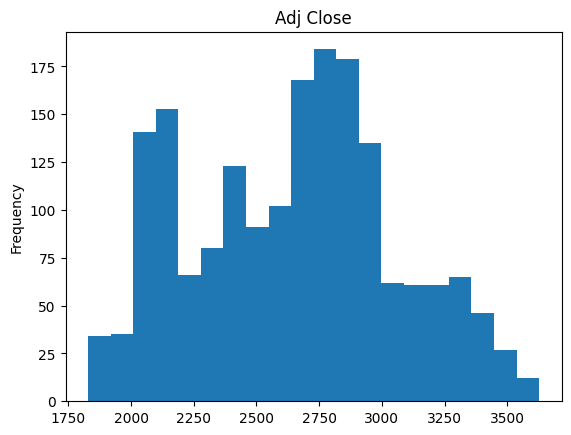

In [28]:
#Plotting the features using a histogram
for i in df.columns:
  df[i].plot(kind='hist', bins=20, title=i)
  plt.show()

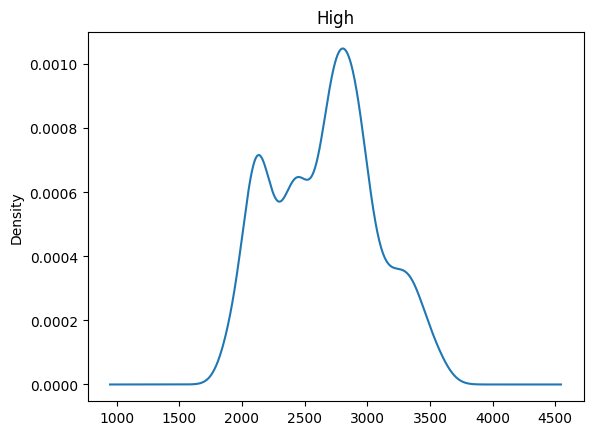

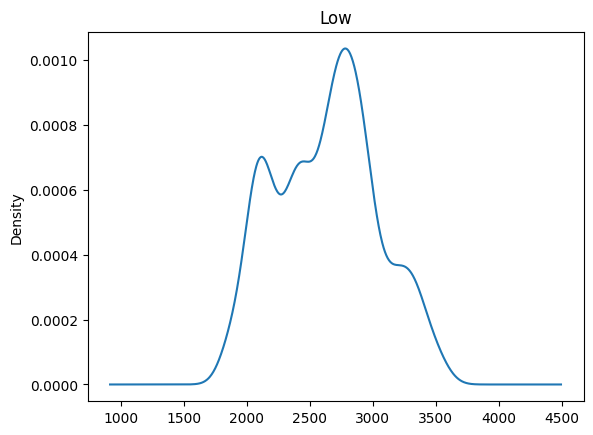

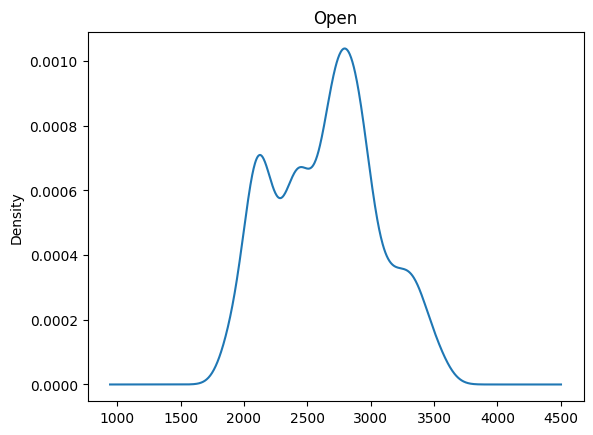

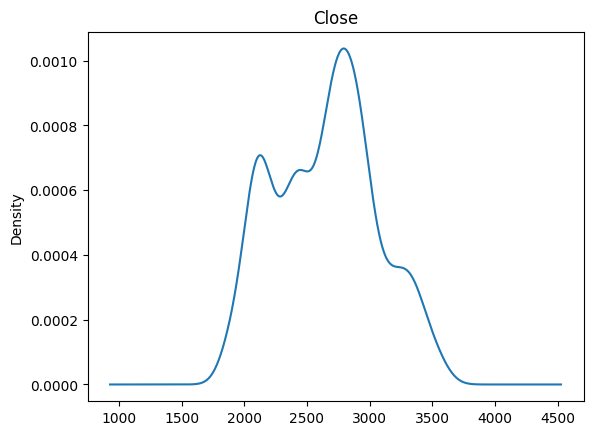

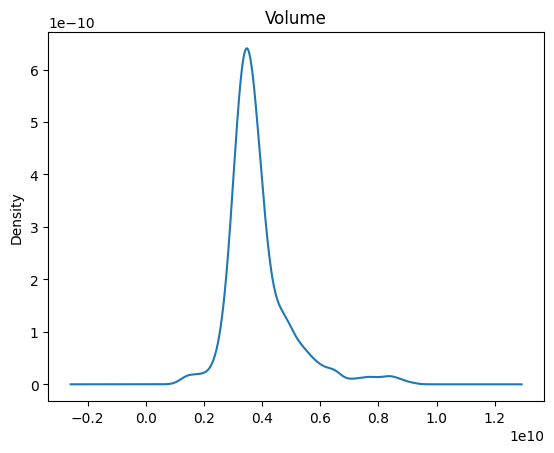

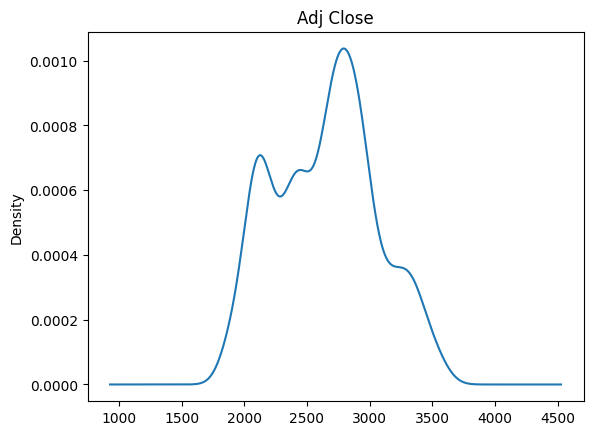

In [29]:
#Plotting the features using a Kernel Density
for i in df.columns:
  df[i].plot(kind='kde', title=i)
  plt.show()

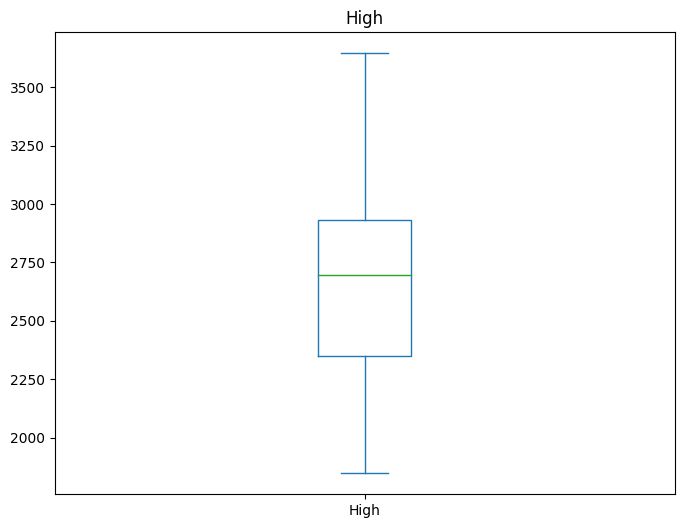

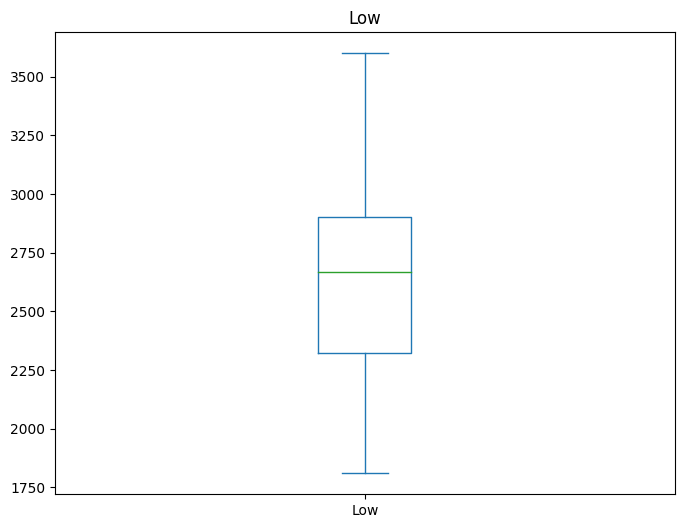

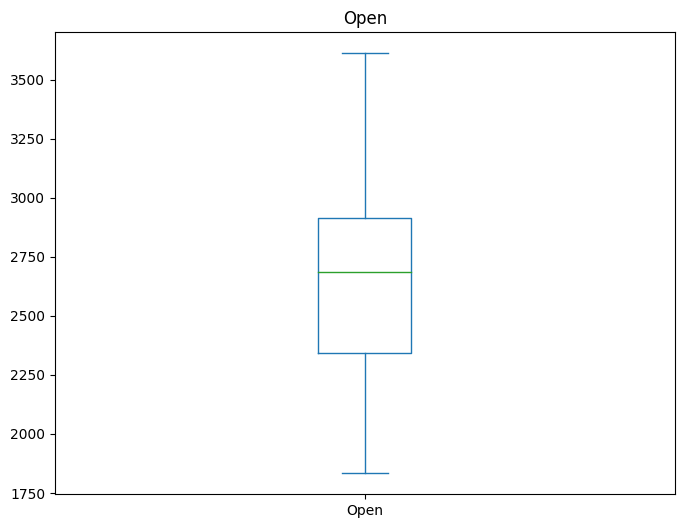

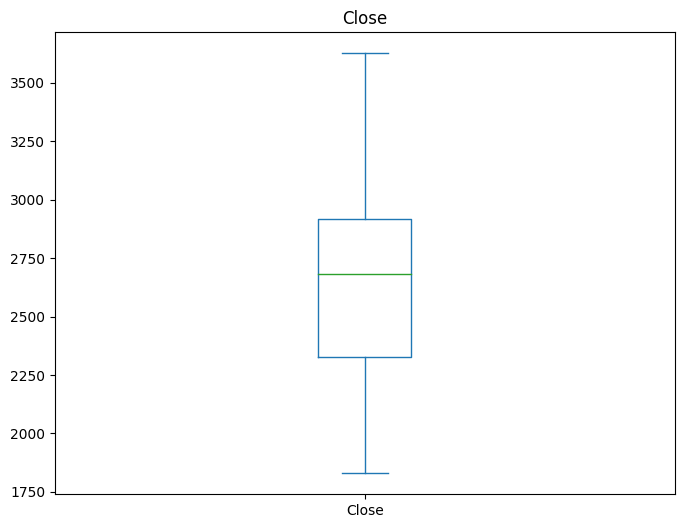

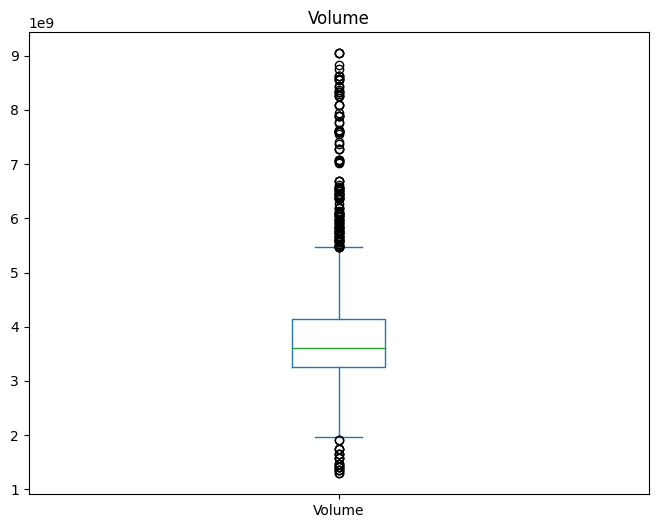

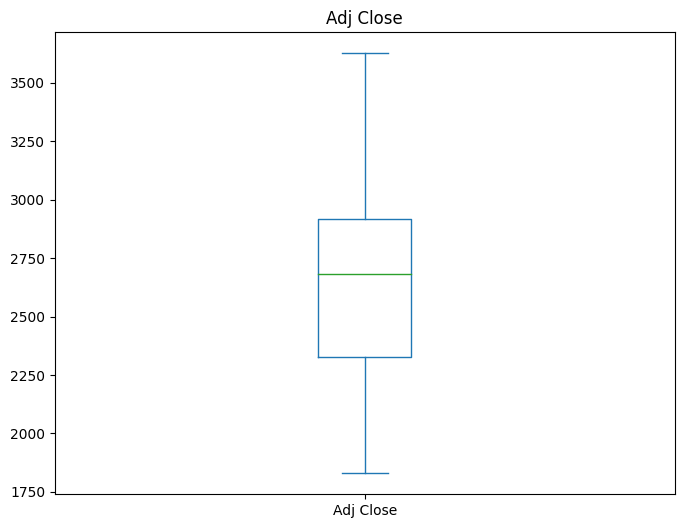

In [30]:
#Plotting the features using boxplot to detect outliers
for i in df.columns:
  df[i].plot(kind='box', figsize=(8,6), title=i)
  plt.show()

In [31]:
#Showing Correlation
df.corr()

,High,Low,Open,Close,Volume,Adj Close
High,1.000000,0.998154,0.999328,0.998958,0.084212,0.998958
Low,0.998154,1.000000,0.998794,0.999020,0.044557,0.999020
Open,0.999328,0.998794,1.000000,0.998344,0.069729,0.998344
Close,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000
Volume,0.084212,0.044557,0.069729,0.063401,1.000000,0.063401
Adj Close,0.998958,0.999020,0.998344,1.000000,0.063401,1.000000


In [32]:
#Removing highly Correlated Feature
df = df.drop('Adj Close', axis=1)

In [33]:
#Creating Window Features:
#Adding rolling mean
df['month_Close'] = df['Close'].rolling(30).mean()
warnings.filterwarnings('ignore')

In [34]:
#Measuring how different the closing price is on a given day from the monthly average
df['month_day_Close'] = df['month_Close'] / df['Close']
warnings.filterwarnings('ignore')

In [35]:
#Measuring the ratio between the Close and Open prices
df['Close_Open']=df['Close'] / df['Open']
warnings.filterwarnings('ignore')

Accuracy: 0.9991788478240684,  MSE: 61.78750382425092, RMSE: 7.860502771722106, MAE: 5.82723019206673


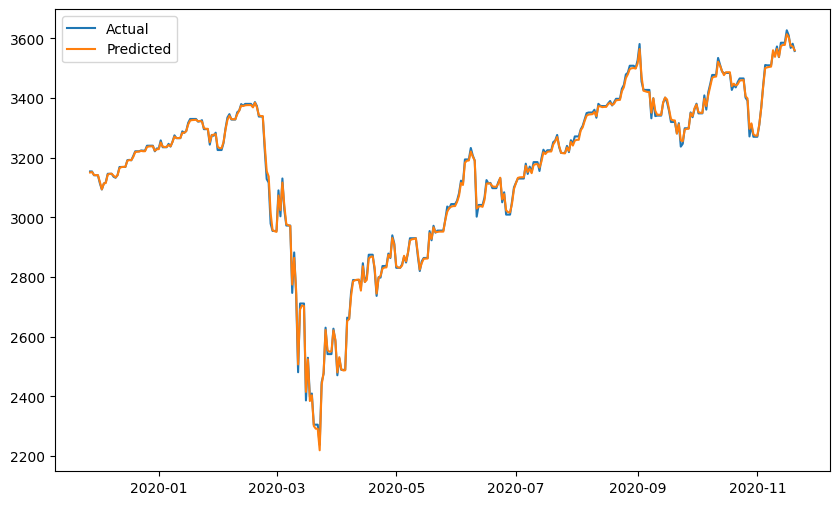

In [36]:
# Create lag features
df['Close_Lag1'] = df['Close'].shift(1)
df['Close_Lag2'] = df['Close'].shift(2)
df['Close_Lag3'] = df['Close'].shift(3)

# Drop rows with missing values created due to some window features
df.dropna(inplace=True)

# Prepare features and target
features = df[['Open', 'High', 'Low', 'Volume', 'Close_Lag1', 'Close_Lag2', 'Close_Lag3','month_Close', 'month_day_Close', 'Close_Open']]
target = df['Close']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

#Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model=linear_model.Ridge(alpha=0.5)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy},  MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

In [37]:
df.corr()['Close']

High               0.998934
Low                0.998993
Open               0.998316
Close              1.000000
Volume             0.070195
month_Close        0.980658
month_day_Close   -0.163294
Close_Open         0.029455
Close_Lag1         0.997673
Close_Lag2         0.996172
Close_Lag3         0.994201
Name: Close, dtype: float64

Accuracy: 0.5501515779404589, MSE: 33848.7943075903, MAE: 132.91300614129582


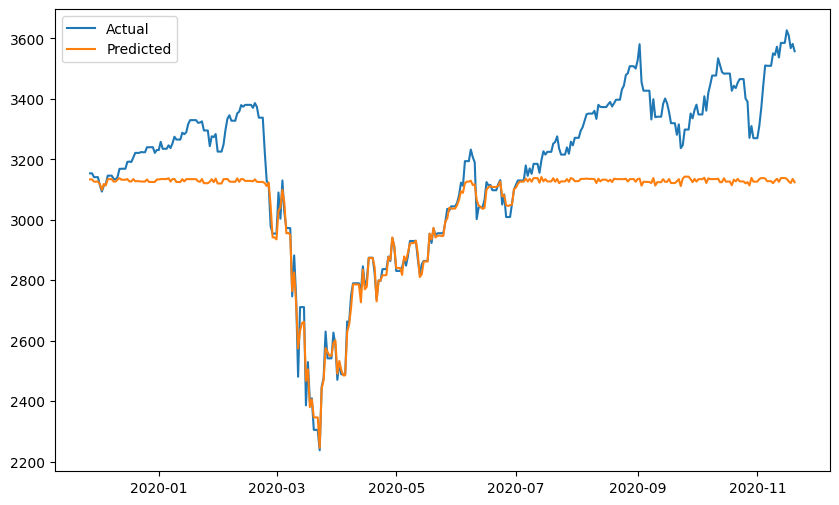

In [38]:
model=GradientBoostingRegressor()
# model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy}, MSE: {mse}, MAE: {mae}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.show()

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Accuracy: 0.5601546804755918, MSE: 33096.11197384048, RMSE: 181.9233684105494, MAE: 130.51452194912036


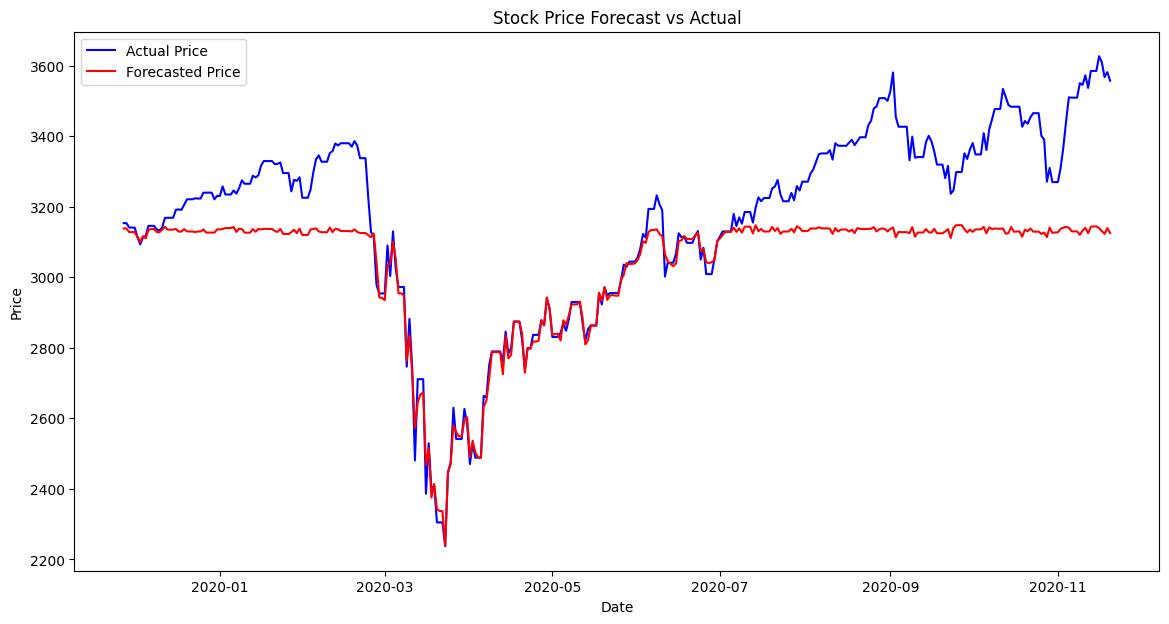

In [39]:
#Hyper Parameter tuning for Gradient Boosting

param_grid = {
    'n_estimators' : [100, 200, 300],
    'learning_rate' : [0.01, 0.05, 0.1],
    'max_depth' : [3, 4, 5]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}')
# print(f'Best Parameters: {grid_search.best_params_}')

# Plot the forecasted versus actual data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='b')
plt.plot(y_test.index, y_pred, label='Forecasted Price', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast vs Actual')
plt.legend()
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1825
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8587.501
Date:                Mon, 27 May 2024   AIC                          17189.001
Time:                        20:21:22   BIC                          17227.563
Sample:                    11-23-2015   HQIC                         17203.226
                         - 11-20-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4091      0.142      2.889      0.004       0.132       0.687
ar.L2          0.1724      0.027      6.308      0.000       0.119       0.226
ar.L3          0.0131      0.013      1.046      0.2

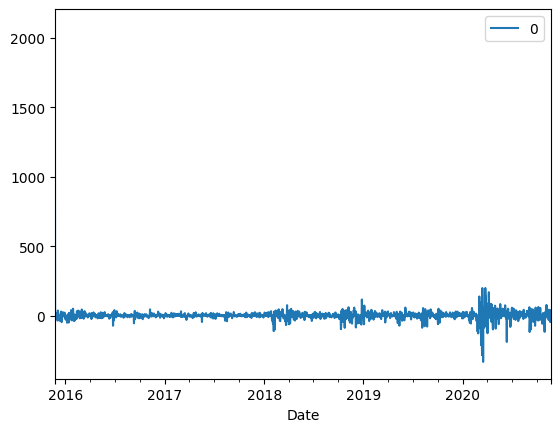

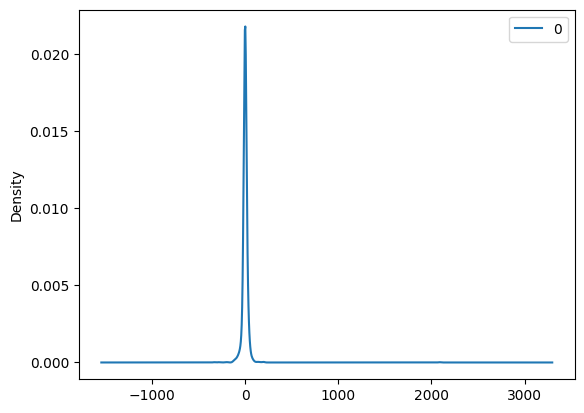

                 0
count  1825.000000
mean      2.031506
std      55.696487
min    -332.506822
25%      -4.313224
50%       0.556049
75%       8.462539
max    2086.590088
predicted=2743.229579, expected=2783.300049
predicted=2781.889662, expected=2791.520020
predicted=2791.033592, expected=2810.919922
predicted=2814.090415, expected=2808.479980
predicted=2807.567117, expected=2822.479980
predicted=2823.766902, expected=2822.479980
predicted=2821.479623, expected=2822.479980
predicted=2824.051209, expected=2832.939941
predicted=2831.961654, expected=2832.570068
predicted=2832.676674, expected=2824.229980
predicted=2825.534952, expected=2854.879883
predicted=2853.293399, expected=2800.709961
predicted=2802.218425, expected=2800.709961
predicted=2804.032755, expected=2800.709961
predicted=2794.098456, expected=2798.360107
predicted=2800.948732, expected=2818.459961
predicted=2817.225478, expected=2805.370117
predicted=2805.692674, expected=2815.439941
predicted=2817.044186, expected=2834.

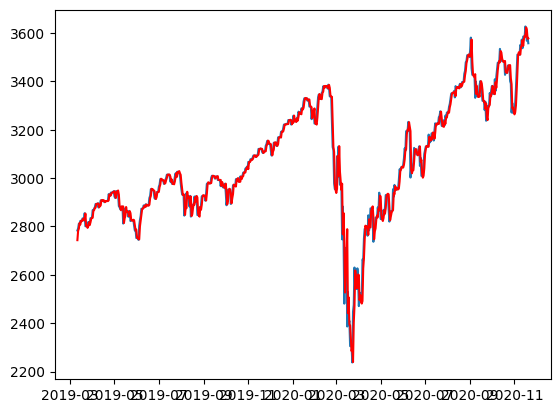

In [40]:
series = pd.read_csv('/content/yahoo_stock.csv', header=0, parse_dates=[0], index_col=0)

# Selecting the 'Close' column as a Series
series = series['Close']

# Fit ARIMA model
model = ARIMA(series, order=(5, 1, 1))
model_fit = model.fit()

# Summary of fit model
print(model_fit.summary())

# Line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

# Density plot of residuals
residuals.plot(kind='kde')
plt.show()

# Summary stats of residuals
print(residuals.describe())

# evaluate an ARIMA model using a walk-forward validation
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

# evaluate forecasts
accuracy = r2_score(test, predictions)
mse = mean_squared_error(test, predictions, squared=False)
mae = mean_absolute_error(test, predictions)
print(f'Accuracy: {accuracy}, MSE: {mse}, MAE: {mae}')

# plot forecasts against actual outcomes
plt.plot(series[size:len(X)])
plt.plot(pd.Series(predictions, index=series.index[size:len(series)]), color='red')
plt.show()

Accuracy: 0.5501186762043038, MSE: 33851.269995054936, RMSE: 183.98714627673024, MAE: 134.7158718532986


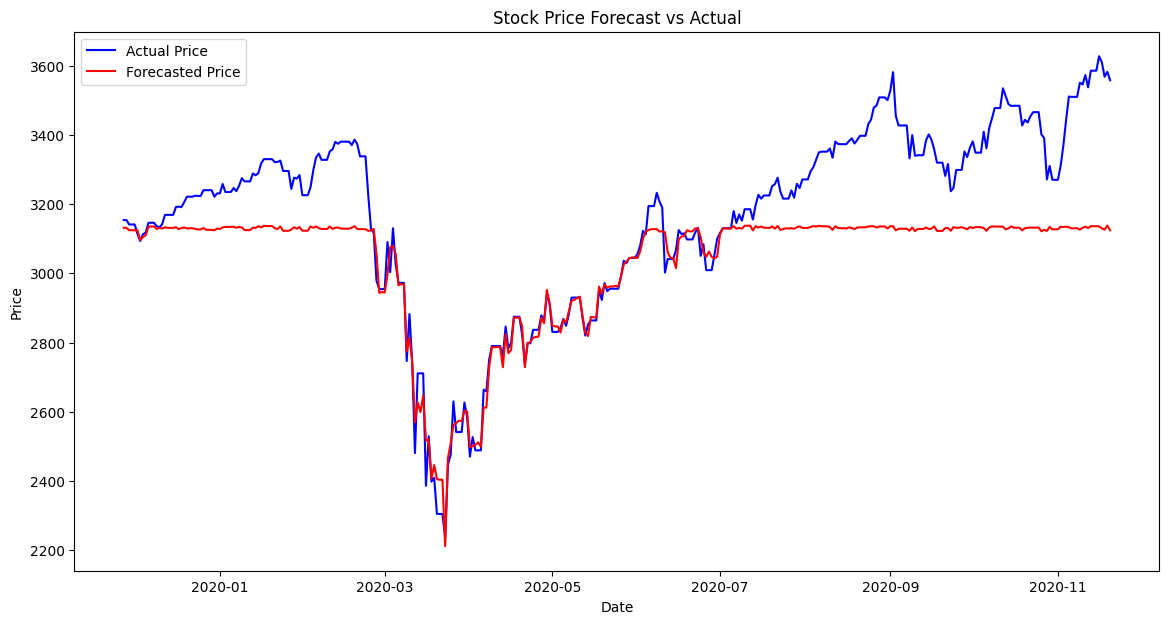

In [41]:
# Create the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
print(f'Accuracy: {accuracy}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}')

# Plot the forecasted versus actual data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual Price', color='b')
plt.plot(y_test.index, y_pred, label='Forecasted Price', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast vs Actual')
plt.legend()
plt.show()

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Mean Squared Error (MSE): 2130.1547143994276
Mean Absolute Error (MAE): 29.48819171857048
R-squared Score: 0.5333893999727474
Best Parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}


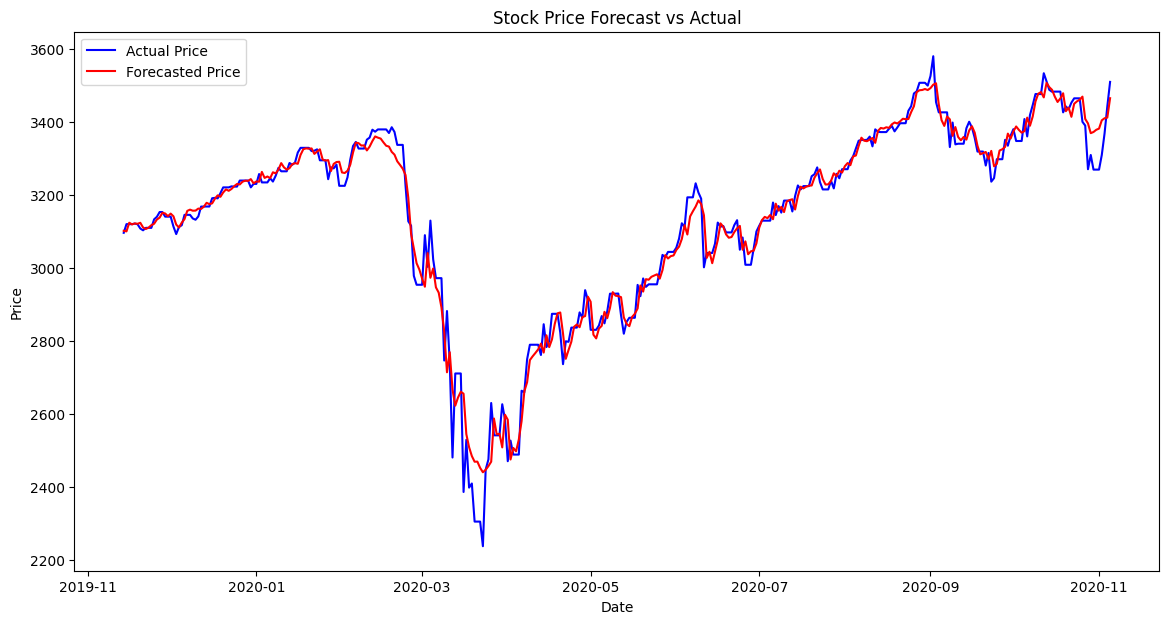

In [42]:
# XGBOOST




# Load your dataset
df = pd.read_csv('/content/yahoo_stock.csv')  # Replace with your data file

# Example preprocessing: Assume 'Date' is your date column and 'Close' is the target
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Decompose the time series to remove trend and seasonality
decomposition = seasonal_decompose(df['Close'], model='additive', period=30)
df['Trend'] = decomposition.trend
df['Seasonal'] = decomposition.seasonal
df['Residual'] = decomposition.resid

# Use residuals as the target for forecasting
df.dropna(inplace=True)  # Drop missing values created by decomposition

# Feature engineering (example: using previous days' residuals as features)
for i in range(1, 6):
    df[f'Lag_{i}'] = df['Residual'].shift(i)

df.dropna(inplace=True)

# Split data into features and target
X = df.drop(columns=['Close', 'Trend', 'Seasonal', 'Residual'])
y = df['Residual']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create the XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror')

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Reconstruct the predicted stock prices by adding back the trend and seasonal components
trend_test = df.loc[X_test.index, 'Trend']
seasonal_test = df.loc[X_test.index, 'Seasonal']
y_pred_reconstructed = y_pred + trend_test + seasonal_test

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared Score: {r2}')
print(f'Best Parameters: {grid_search.best_params_}')

# Plot the forecasted versus actual data
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, df.loc[y_test.index, 'Close'], label='Actual Price', color='b')
plt.plot(y_test.index, y_pred_reconstructed, label='Forecasted Price', color='r')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Forecast vs Actual')
plt.legend()
plt.show()



Mean Squared Error (MSE): 0.00856323681962975
Root Mean Squared Error (RMSE): 0.09253775888592586
Mean Absolute Error (MAE): 0.05716973662395451
R-squared (R2): 0.9803041606190526


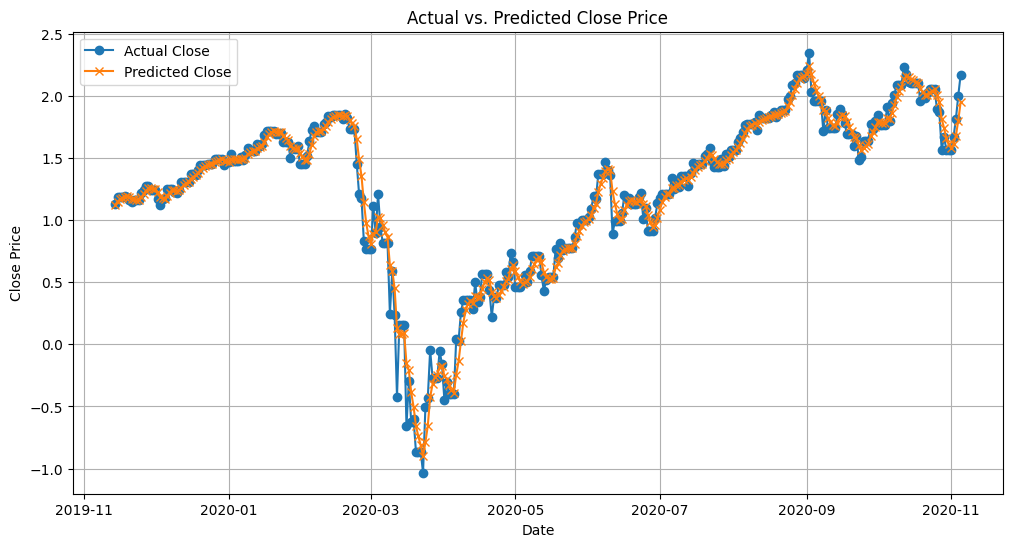

In [43]:
######################################
############## WMA Model #############
######################################

# Assuming df is your DataFrame and it contains 'Date' and 'Close' columns

# Sort by date if not already sorted
df = df.sort_values('Date')

# Define weighted moving average function
def weighted_moving_average(prices, weights):
    return np.dot(prices, weights) / sum(weights)

window_size = 5  # Adjust as needed
weights = np.arange(1, window_size + 1)  # Example weights, adjust as needed

# Compute WMA and add it as a feature
df['WMA'] = df['Close'].rolling(window=window_size).apply(lambda prices: weighted_moving_average(prices, weights), raw=True)
df.dropna(inplace=True)  # Drop rows with NaN values after computing WMA

# Standardize numeric columns
scaler = StandardScaler()
df[['Close', 'WMA']] = scaler.fit_transform(df[['Close', 'WMA']])

# Features and target variable
X = df[['WMA']]  # Features
y = df['Close']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Initialize and fit a model (e.g., Linear Regression)
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared (R2): {r2}')

# Plotting Predictions vs. Actual
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test, label='Actual Close', marker='o')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted Close', marker='x')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


